# 머신러닝 프로젝트 처음부터 끝까지

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2.1 실제 데이터로 작업하기
- StatLib 저장소에 있는 캘리포아니 주택 가격 데이터셋을 사용
- 이 데이터는 1990년 캘리포니아 인구 조사 데이터를 기반(교육 목적이므로 몇 개의 범주형 데이터는 제외)

## 2.2 큰 그림 보기
- 데이터는 블록 그룹마다 인구, 중간 소득, 중간 주택 가격 등의 데이터를 담고 있음
- 이를 바탕으로 다른 측정 데이터가 주어졌을 때, 구역의 중간 주택 가격을 예측

#### 2.2.1 문제 정의
- 레이블된 훈련 샘플이 있으므로 전형적인 지도 학습
- 값을 예측해야 하므로 전형적인 회귀 문제(그 중에서도 변수가 여러 개인 다변량 회귀)
- 시스템으로 들어오는 데이터에 연속적인 흐름이 없고 빠르게 변화하는 데이터에 적응하지 않아도 되고, 데이터가 메모리에 들어가기에 작으므로 배치학습

#### 2.2.2 성능 측정 지표 선택
- 회귀 문제의 전형적인 성능 지표는 평균 제곱 오차(RMSE)이나 경우에 따라 다른 함수를 사용할 수 있음
- 예를 들어 이상치로 보이는 구역이 많을 경우는 평균 절대 오차(MAE)를 고려할 수 있음
- RMSE, MAE 모두 예측값의 벡터와 타깃값의 벡터 사이의 거리를 재는 방법

## 2.3 데이터 가져오기

#### 2.3.1 작업환경 만들기

In [2]:
import sklearn

print(sklearn.__version__)

0.22.1


#### 2.3.2 데이터 다운로드

In [3]:
# housing data 불러오는 함수 생성 및 실행
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = os.path.join('data','housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [4]:
# housing 데이터 읽어 들이는 함수(데이터 프레임 반환) 생성 및 실행
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

#### 2.3.3 데이터 구조 훑어보기

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
# 데이터 개요 확인(total_bedrooms null값 존재, ocean_proximity 타입 object -> 같은 특성이 반복되므로 범주형으로 예상됨)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing['ocean_proximity'].value_counts() # 확인 결과 5개의 범주로 나뉜 범주형

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
# describe ==> 숫자형 특정의 요약 정보 확인(Null값은 제외됨)
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


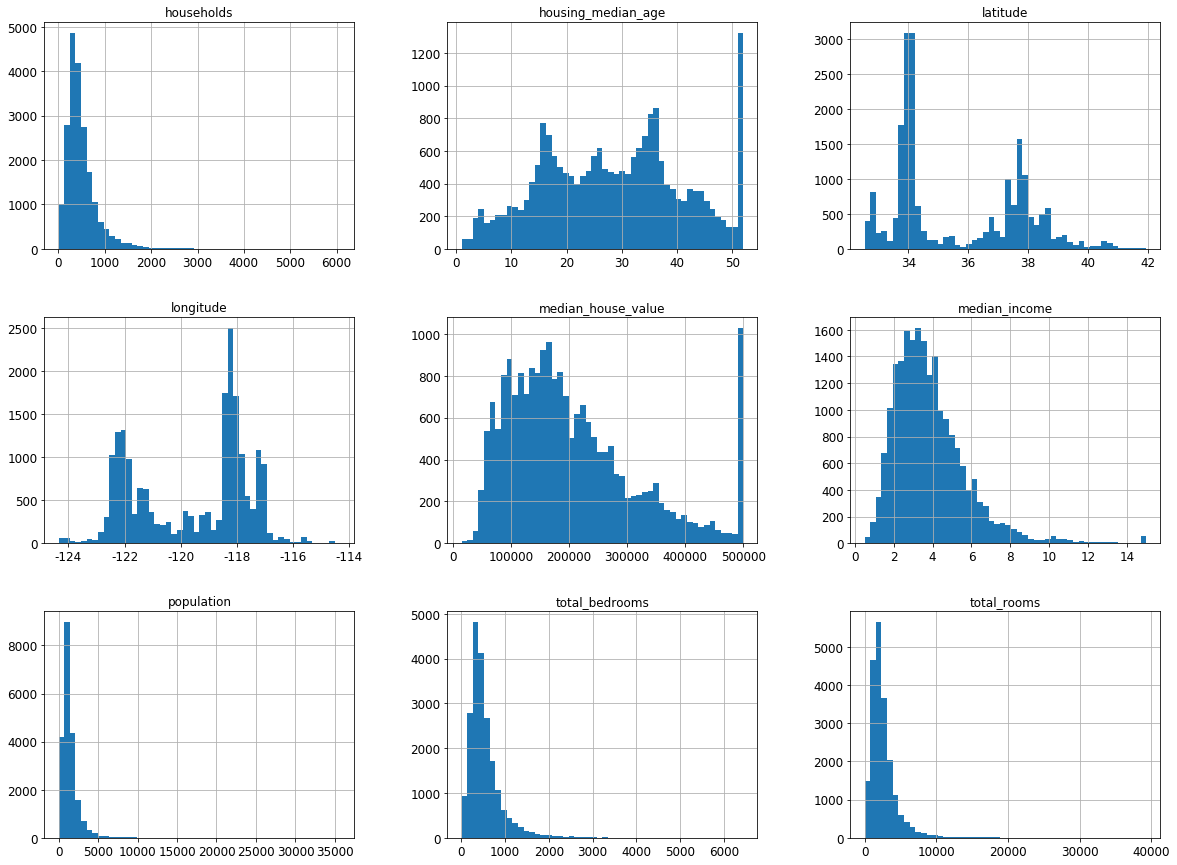

In [9]:
# %matplotlib inline ==> 주피터 노트북의 매직 명령(맷플롯립이 주피터 자체의 백엔드를 사용하도록 함 -> 그래프가 노트북 안에 그려짐)
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

##### 히스토그램 분석
1. median imcome이 $가 아님 ==> 데이터 스케일을 조정한 것으로 문제는 X
2. housing median age, median house value의 최대값, 최소값 한정 ==> 문제가 된다면 한계값 밖 정확한 레이블 구하기 or 훈련 세트에서 이런 구역 제거
3. 특성들의 스케일이 제각각
4. 꼬리가 두꺼움(가운데에서 왼쪽보다 오른쪽으로 더 멀리 뻗어있음)은 알고리즘이 패턴 찾기 힘듬 ==> 종 모양의 분포로 변형해야함

#### 2.3.4 테스트 세트 만들기

##### Train_Test 미리 분리
1. 일반적인 분리
2. 계층적 분리(편향성 방지)
- 데이터 스누핑: 테스트로 일반화 오차를 추정하여 시스템을 론칭했을 때, 기대한 성능이 나오지 않는 현상

In [10]:
# 예시를 위해서 만든 것입니다. 사이킷런에는 train_test_split() 함수가 있음
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [12]:
# 예시를 위해서 만든 것입니다. 사이킷런에는 train_test_split() 함수가 있음
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [14]:
# 이 버전의 test_set_check() 함수가 파이썬 2도 지원합니다.
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [15]:
housing_with_id = housing.reset_index()   # `index` 열이 추가된 데이터프레임이 반환됩니다.
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [17]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [18]:
# 사이킷런의 train_test_split은 타깃이 대해 계층적 샘플링을 따름
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) # random_state ==> 난수 발생의 고정을 위해

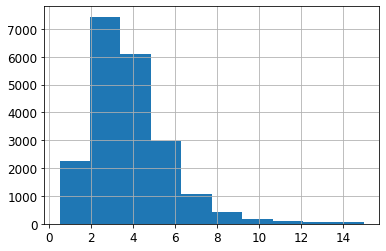

In [19]:
# 하지만, 중간 소득이 주택 가격 예측에 매우 큰 영향을 준다면, 주택 가격에 대해 계층적 샘플링을 해야함
housing["median_income"].hist() # 현재 분포는 연속형이므로 계층적 샘플링을 위해 범주형으로 만들어야함

In [20]:
# 계층적 샘플링을 위한 범주화 작업 작업
import numpy as np

housing['income_cat'] = np.ceil(housing['median_income'] / 1.5) # ceil ==> 값 올림 처리
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True) # where ==> 5보다 큰 값들은 5.0으로 합치기

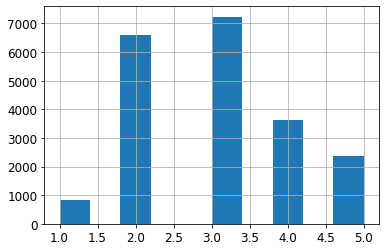

In [21]:
# 범주화 작업 결과
housing["income_cat"].hist()

In [22]:
# StratifiedShuffleSplit를 이용한 계층적 샘플링(소득을 기준으로 분류)
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [23]:
# 분리 확인
strat_train_set.income_cat.value_counts(), strat_test_set.income_cat.value_counts()

(3.0    5789
 2.0    5265
 4.0    2911
 5.0    1889
 1.0     658
 Name: income_cat, dtype: int64,
 3.0    1447
 2.0    1316
 4.0     728
 5.0     473
 1.0     164
 Name: income_cat, dtype: int64)

In [24]:
# train, test에서 'income_cat' 열 드랍하여 원래의 상태로 복귀
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## 2.4 데이터 이해를 위한 탐색과 시각화

In [25]:
# 훈련 세트 손상을 방지하기 위한 복사본 사용
housing = strat_train_set.copy()

#### 2.4.1 지리적 데이터 시각화

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


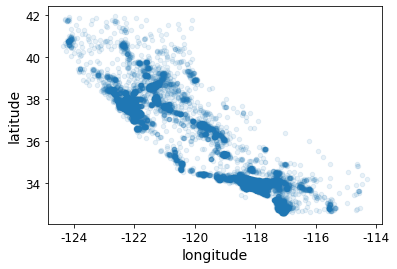

In [26]:
# 주택의 분포 산점도 만들기(밀집된 몇 군데의 지역이 보임)
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1); # alpha ==> 점 진하기

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
C:\Users\Yoo\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Yoo\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Yoo\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Yoo\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0, flags=flags)


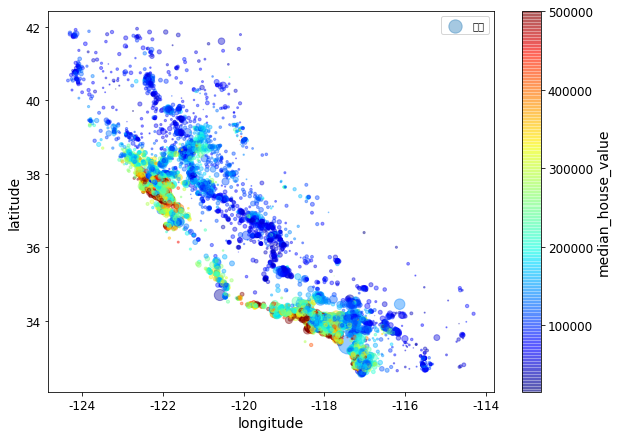

In [27]:
# s ==> 원의 반지름, c ==> 원의 색깔, cmap ==> 컬러 맵, colorbar ==> 컬러바 표시 여부
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="인구", 
                  figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
ax.set(xlabel='longitude', ylabel='latitude')
plt.legend()
plt.savefig("housing_prices_scatterplot") # 주택 가격은 인구 밀집과 관련이 매우 큼

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


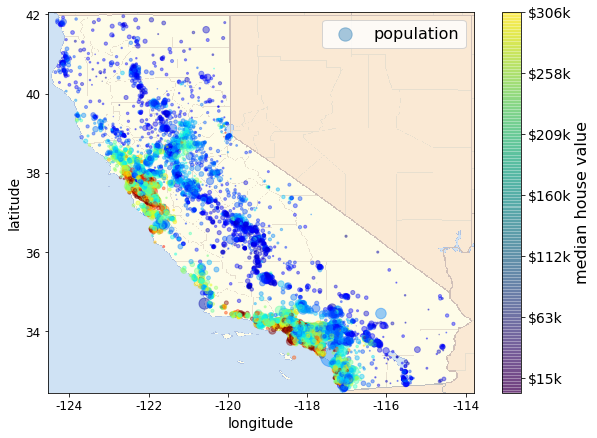

In [28]:
import matplotlib.image as mpimg

california_img=mpimg.imread('images/2/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7), s=housing['population']/100, label="population",
                       c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=False, alpha=0.4,)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.xlabel("longitude", fontsize=14)
plt.ylabel("latitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('median house value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

#### 2.4.2 상관관계 조사

In [29]:
corr_matrix = housing.corr() # corr ==> 표준 상관계수 계산
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


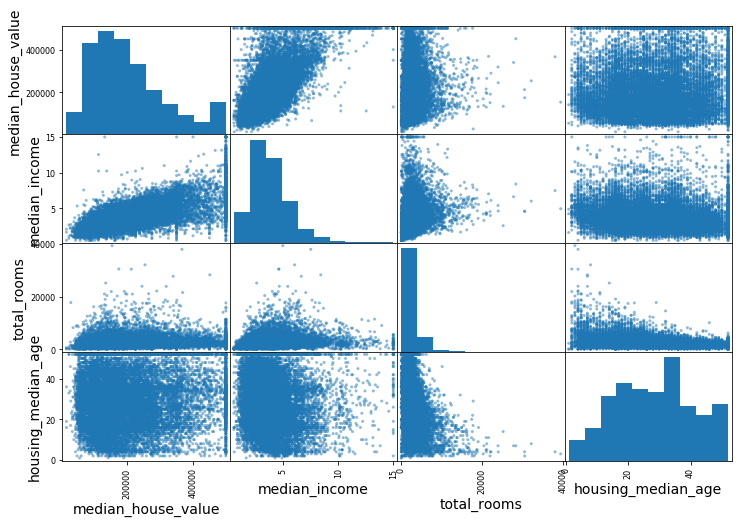

In [30]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"] # median_house_value와 상관관계 높은 것들만
scatter_matrix(housing[attributes], figsize=(12, 8));

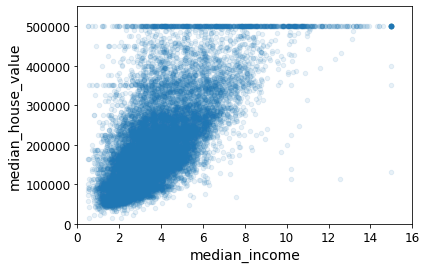

In [31]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1) # 가장 의미있는 상관관계만
plt.axis([0, 16, 0, 550000]); # x,y 범위 설정

##### 상관관계 분석
1. 매우 강한 상관관계를 보여줌
2. 500,000 부분에서 직선에 가까운 형태를 볼 수 있음 ==> 제거 필요

### 2.4.3 특성 조합으로 실험

In [32]:
# 방 개수는 가구의 수의 영향을 미칠 것이라 예상하고 변수 생성
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] # 가구 당 방 개수
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] # 방당 침대 개수
housing["population_per_household"]=housing["population"]/housing["households"] # 가구 당 인원

In [33]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False) # bedrooms_per_room 특성은 다른 두 개의 새로운 변수보다 상관관계가 높음

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

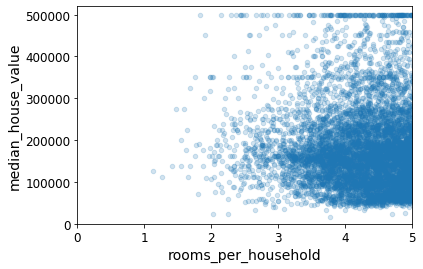

In [34]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", alpha=0.2)
plt.axis([0, 5, 0, 520000]);

## 2.5 머신러닝 알고리즘을 위한 데이터 준비

In [35]:
housing = strat_train_set.drop("median_house_value", axis=1) # 훈련 세트를 위해 레이블 삭제
housing_labels = strat_train_set["median_house_value"].copy() # 훈련 세트 손상을 방지하기 위한 복사본 사용

#### 2.5.1 데이터 정제

In [36]:
housing.dropna(subset=["total_bedrooms"])    # 누락값 포함 행을 제거
housing.drop("total_bedrooms", axis=1)       # 전체 특성 삭제
median = housing["total_bedrooms"].median()
housing['total_bedrooms'].fillna(median, inplace=True) # 결측값 특정 값으로 채우기(나중에 테스트 세트도 훈련 세트의 중간값으로 채움)

In [37]:
from sklearn.impute import SimpleImputer # SimpleImputer ==> 누락된 값을 쉽게 다루게 해줌

imputer = SimpleImputer(strategy="median") # SimpleImputer의 객체 생성(중간값)

In [38]:
housing_num = housing.drop('ocean_proximity', axis=1) # 수치형 데이터만 다룰 수 있으므로 텍스트 특성 제거

In [39]:
imputer.fit(housing_num) # housing_num의 중간값들 statistics_ 속성에 저장

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [40]:
imputer.statistics_, housing_num.median().values # 두 값이 동일한 것을 알 수 있음

(array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]),
 array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]))

In [41]:
X = imputer.transform(housing_num) # housing_num 누락값 중간값으로 대체
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index = list(housing.index.values)) # 데이터 프레임으로 변환

In [42]:
imputer.strategy # 하이퍼파라미터 공개 인스턴스(파라미터의 경우 _ 접미사를 붙여야 함)

'median'

In [43]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


#### 2.5.2 텍스트와 범주형 특성 다루기

In [44]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [45]:
housing_cat_encoded, housing_categories = housing_cat.factorize() # factorize ==> 각 카테고리를 정수값으로 매칭(변환, 카테고리 리스트)
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [46]:
housing_categories # 카테고리 리스트 확인

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

##### factorize 변환 방식 문제점
- 텍스트를 숫자로 변환해주나 모델에서 인식할 때 범주가 아닌 특성으로 이해함(ex - 0과 1은 0과 4보다 비슷하다)

In [47]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto', sparse=True) # sparse=True이므로 희소행렬(scipy)의 형태 False면 밀집행렬로 반환
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1)) # housing_cat_encoded는 1차원이므로 2차원으로 바꿔야함
housing_cat_1hot;

In [48]:
housing_cat_1hot.toarray() # toarray ==> 희소행렬 -> 밀집행렬

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [49]:
encoder.categories_

[array([0, 1, 2, 3, 4], dtype=int64)]

##### future_encoders.py를 이용한 새로운 방법

In [50]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [51]:
# from future_encoders import OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) # 데이터 프레임이 들어가야함
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [52]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### 2.5.3 나만의 변환기

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

# 컬럼 인덱스
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [54]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, 
                                     columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


#### 2.5.4 특성 스케일링
- 1. MinMaxScaler(정규화): 0~1 사이의 범위로 변환(이상치에 민감)
- 2. StandardScaler(표준화): (값-평균)/표준편차 의 식으로 상한과 하한이 없음(이상치의 둔감)

#### 2.5.5 변환 파이프라인

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 숫자 특성 처리 파이프라인(모든 메서드가 fit_transform() 메서드를 가지고 있어야 함)
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr[:1]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753]])

In [56]:
# 예전 방법으로 지금은 이렇게 하지 않음
"""
from sklearn.base import BaseEstimator, TransformerMixin

# 데이터 프레임의 필요한 특성을 선택하여 넘파이 배열로 변환하는 함수
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
        
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# 숫자의 특성을 다루는 파이프라인
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# 범주의 특성을 다루는 파이프라인
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(categories='auto', sparse=False)),
    ])
"""

'\nfrom sklearn.base import BaseEstimator, TransformerMixin\n\n# 데이터 프레임의 필요한 특성을 선택하여 넘파이 배열로 변환하는 함수\nclass DataFrameSelector(BaseEstimator, TransformerMixin):\n    def __init__(self, attribute_names):\n        self.attribute_names = attribute_names\n    def fit(self, X, y=None):\n        return self\n    def transform(self, X):\n        return X[self.attribute_names].values\n        \nnum_attribs = list(housing_num)\ncat_attribs = ["ocean_proximity"]\n\n# 숫자의 특성을 다루는 파이프라인\nnum_pipeline = Pipeline([\n        (\'selector\', DataFrameSelector(num_attribs)),\n        (\'imputer\', SimpleImputer(strategy="median")),\n        (\'attribs_adder\', CombinedAttributesAdder()),\n        (\'std_scaler\', StandardScaler()),\n    ])\n\n# 범주의 특성을 다루는 파이프라인\ncat_pipeline = Pipeline([\n        (\'selector\', DataFrameSelector(cat_attribs)),\n        (\'cat_encoder\', OneHotEncoder(categories=\'auto\', sparse=False)),\n    ])\n'

In [57]:
# ColumnTransformer라는 새로운 방식의 파이프라인
from sklearn.compose import ColumnTransformer # 이를 이용하면 사용자 정의 함수 DataFrameSelector와 사이킷런의 FeatureUnion 안써도 됨

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# num_attribs를 써넣으면 DataFrameSelector라는 사용자 정의 함수를 대신하게 됨
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(categories='auto'), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [58]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [59]:
housing_prepared.shape

(16512, 16)

## 2.6 모델 선택과 훈련

#### 2.6.1 훈련 세트에서 훈련하고 평가하기

In [60]:
# 선형 회귀 훈련
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
# 훈련된 선형 회귀에 몇 개의 데이터 적용
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))
print("레이블:", list(some_labels)) # 정확한 예측은 아님

예측: [210644.60459286 317768.80697211 210956.43331178  59218.98886849]
레이블: [286600.0, 340600.0, 196900.0, 46300.0]


In [62]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse # 주택 가격은 120,000 ~ 265,000 사이이고 예측 오차는 68,628 ==> 과소적합

68628.19819848923

In [63]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [64]:
# 결정 트리 훈련(기존의 선형 회귀로 과소적합이 발생했으므로 더 복잡한 모델을 사용)
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [65]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse # 오차는 0 ==> 과대적합 (이는 훈련 세트와 테스트 세트가 똑같기 때문)

0.0

#### 2.6.2 교차 검증을 사용한 평가

In [66]:
# 교차 검증
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10) # 교차 검증 시행
tree_rmse_scores = np.sqrt(-scores)

In [67]:
# 점수 프린트 함수
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())

display_scores(tree_rmse_scores) # 디시전트리 평균 RMSE = 71407 (선형회귀보다 결과가 나쁨)

점수: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
평균: 71407.68766037929
표준편차: 2439.4345041191004


In [68]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores) # 선형회귀 평균 RMSE = 69052 (디시전트리보다 결과가 좋음)

점수: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
평균: 69052.46136345083
표준편차: 2731.674001798349


In [69]:
# 랜덤 포레스트 모델 훈련
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [70]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse # 가장 좋은 성능을 보임

21933.31414779769

In [71]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores) # 훈련 세트에 대한 점수(21933)가 검증 세트에 대한 점수(52583)보다 훨신 낮으므로 이는 과대적합

점수: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
평균: 52583.72407377466
표준편차: 2298.353351147122


In [72]:
# 서포트 벡터 머신 훈련
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse # 서포트 벡터 머신의 경우 최악의 RMSE를 보임

111094.6308539982

## 2.7 모델 세부 튜닝

#### 2.7.1 그리드 탐색

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 하이퍼파라미터 12(=3×4)개의 조합을 시도
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도 (총 12 + 6 = 18번)
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 폴드에서 훈련하면 총 (12+6)*5=90번의 훈련.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [74]:
grid_search.best_params_ # best_params_ ==> 최고의 파라미터 조합

{'max_features': 8, 'n_estimators': 30}

In [75]:
grid_search.best_estimator_ # best_estimator_ ==> 최적의 추정기에 접근

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [76]:
cvres = grid_search.cv_results_ # cv_results_ ==> 그리드 서치 결과 저장
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

#### 2.7.2 랜덤 탐색
- 1. 그리드 탐색: 지정한 하이퍼파라미터 탐색
- 2. 랜덤 탐색: 하이퍼파라미터에 지정한 횟수만큼 탐색

In [77]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, 
                                scoring='neg_mean_squared_error', random_state=42, n_jobs=-1) # 10회 반복
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [78]:
cvres = rnd_search.cv_results_ # cv_results_ ==> 그리드 서치 결과 저장
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


#### 2.7.3 앙상블 방법 -> 7장

#### 2.7.4 최상의 모델과 오차 분석

In [79]:
# 특성 중요도
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [80]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
# cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

#### 2.7.5 테스트 세트로 시스템 평가하기

In [81]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [82]:
final_rmse # 교차 검증보다 성능이 낮은 것이 일반적(하이퍼파라미터 튜닝 시도시 일반화되기 어려움)

47730.22690385927

#### 2.7.6 신뢰구간

In [83]:
from scipy import stats

In [84]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1, loc=np.mean(squared_errors), scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

## 추가. 전처리를 포함한 파이프라인과 모델 저장

In [85]:
# 전처리와 예측을 포함한 파이프라인
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849])

In [86]:
# joblib을 이용한 모델 저장
my_model = full_pipeline_with_predictor

from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
